Clean and upload DataSet

In [0]:
!rm -rf 'data/bikeDataSet/' 

In [6]:
from google.colab import files
def getLocalFiles():
    _files = files.upload()
    if len(_files) >0:
       for k,v in _files.items():
         open(k,'wb').write(v)
getLocalFiles()

Saving urls_road.csv to urls_road.csv


Organize dataset and download images

In [8]:
import os
from fastai.vision import *

path = Path('data/bikeDataSet')

def createDirectory(label):
  folder = label
  file = 'urls_' + label + '.csv'
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True) 
  os.rename(file, path/file)
  download_images(path/file, dest, max_pics=200)
  
createDirectory('road')
createDirectory('electric')
createDirectory('mountain')



Error https://static.cyclelab.eu/velos/look/2007/highres/695-BLACK_ACID_MATT-copie.jpg HTTPSConnectionPool(host='static.cyclelab.eu', port=443): Max retries exceeded with url: /velos/look/2007/highres/695-BLACK_ACID_MATT-copie.jpg (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:847)'),))
Error https://static.cyclelab.eu/velos/lapierre/2007/highres/A300-Shaper-100.jpg HTTPSConnectionPool(host='static.cyclelab.eu', port=443): Max retries exceeded with url: /velos/lapierre/2007/highres/A300-Shaper-100.jpg (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:847)'),))
Error https://static.cyclelab.eu/velos/trek/2007/highres/1400000_2016.jpg HTTPSConnectionPool(host='static.cyclelab.eu', port=443): Max retries exceeded with url: /velos/trek/2007/highres/1400000_2016.jpg (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:847)'),))
Error https://s

Error https://www.altermove.com/23585-large_default/velo-electrique-45kmh-speed-bike-stromer-st5-2018.jpg HTTPSConnectionPool(host='www.altermove.com', port=443): Max retries exceeded with url: /23585-large_default/velo-electrique-45kmh-speed-bike-stromer-st5-2018.jpg (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x7f897faa5780>, 'Connection to www.altermove.com timed out. (connect timeout=4)'))


Error https://uc-domont.webnode.fr/_files/200000634-48ab949a56/image%20vtt.gif HTTPSConnectionPool(host='uc-domont.webnode.fr', port=443): Max retries exceeded with url: /_files/200000634-48ab949a56/image%20vtt.gif (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:847)'),))


Verify images

In [9]:
classes = ['road','electric','mountain']
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

road


cannot identify image file <_io.BufferedReader name='data/bikeDataSet/road/00000010.jpg'>
cannot identify image file <_io.BufferedReader name='data/bikeDataSet/road/00000007.jpg'>
cannot identify image file <_io.BufferedReader name='data/bikeDataSet/road/00000013.jpg'>
cannot identify image file <_io.BufferedReader name='data/bikeDataSet/road/00000018.jpg'>
cannot identify image file <_io.BufferedReader name='data/bikeDataSet/road/00000049.jpg'>
cannot identify image file <_io.BufferedReader name='data/bikeDataSet/road/00000030.jpg'>
electric


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


mountain


cannot identify image file <_io.BufferedReader name='data/bikeDataSet/mountain/00000026.jpg'>


View images

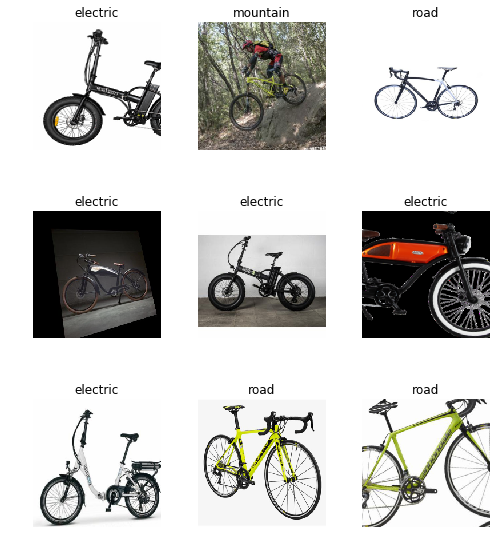

In [10]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(7,8))

Training

In [16]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(10)
learn.save('stage-1')

epoch,train_loss,valid_loss,error_rate,time
0,1.628537,1.241244,0.708333,00:02
1,1.533035,1.169065,0.708333,00:02
2,1.438185,1.059704,0.500000,00:02
3,1.283495,1.031766,0.500000,00:02
4,1.164521,1.056404,0.458333,00:02
5,1.070945,1.049840,0.458333,00:02
6,0.974900,1.025577,0.458333,00:02
7,0.885799,1.012074,0.416667,00:02
8,0.831845,0.996027,0.375000,00:02
9,0.766254,0.970406,0.333333,00:02


Result interpretation

[('electric', 'mountain', 2)]

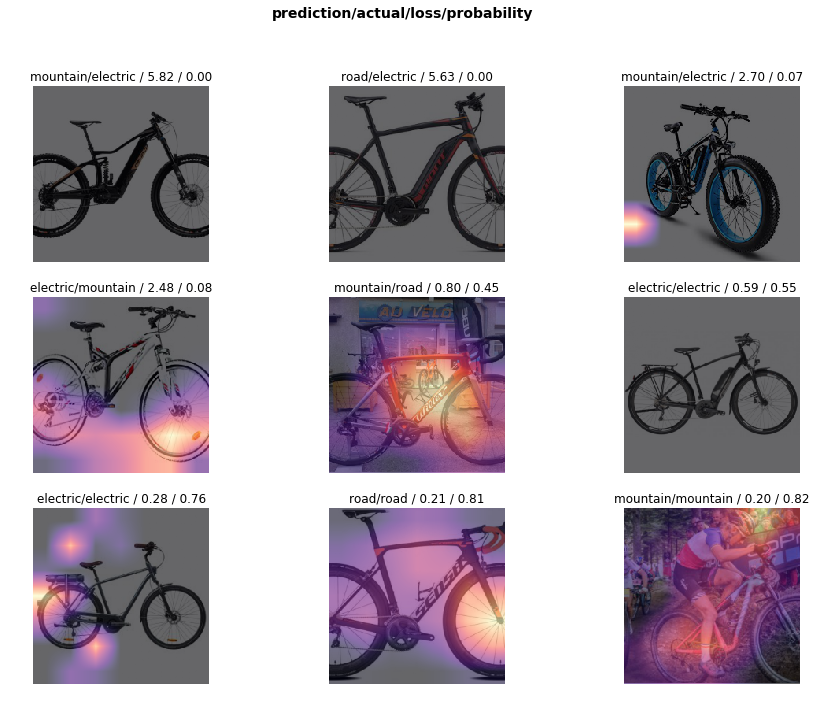

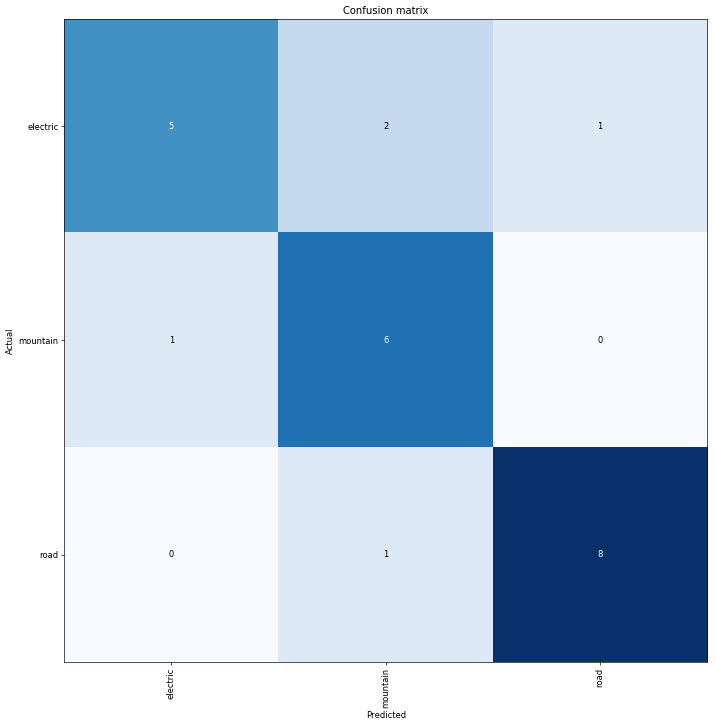

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

interp.most_confused(min_val=2)

Unfreezing, fine-tuning, and learning rates

epoch,train_loss,valid_loss,error_rate,time
0,0.229361,0.867581,0.250000,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


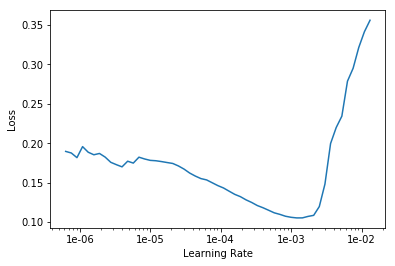

In [13]:
learn.unfreeze()
learn.fit_one_cycle(1)
learn.load('stage-1')
learn.lr_find()
learn.recorder.plot()

Improve the model

In [17]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.364454,0.959643,0.333333,00:02
1,0.356390,0.969722,0.333333,00:02
2,0.321238,0.980321,0.291667,00:02
3,0.289659,0.942688,0.291667,00:02
4,0.270271,0.914762,0.291667,00:02
5,0.260187,0.953763,0.291667,00:02
6,0.243659,0.972557,0.250000,00:02
7,0.231147,0.986420,0.208333,00:02
8,0.213822,0.996920,0.208333,00:02
9,0.203125,0.988470,0.208333,00:02
